# Example of usage Spark OCR for Text Recognition by ImageToTextV2

This notebook demonstrates a pipeline for detecting text using __ImageTextDetectorV2__ and text recognition using __ImageToTextV2__ on images.

__ImageToTextV2__ is based on the transformer architecture and combines CV and NLP in one model. It is a visual encoder-decoder model. The Encoder is based on ViT and the decoder on the RoBERTa model.

__ImageToTextV2__ can work with CPU, but prefer to use GPU for having an acceptable performance.

Note: Work on __ImageToTextV2__ is in-progress. So, current implementation is only for demonstrating the capabilities of the model. New versions will focus on performance and scalability.

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.11/"

In [ ]:
# install from PYPI using secret
%pip install torch
%pip install transformers==4.15.0
%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session

In [3]:
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.11.0rc1



# Read image and display it

In [4]:
import pkg_resources
import pyspark.sql.functions as f
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


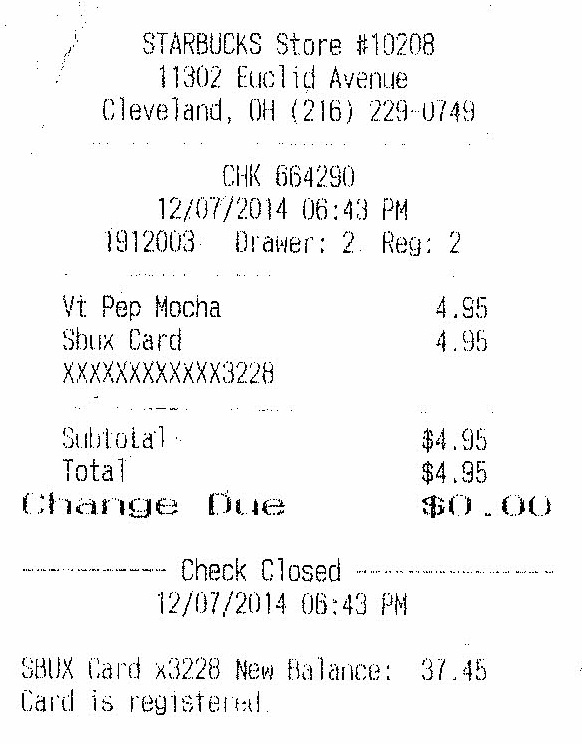

In [5]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

# Define OCR Pipeline for detect and recognize text 

In [6]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True) \
    .setSizeThreshold(20)

ocr = ImageToTextV2.pretrained("ocr_base_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text")

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    draw_regions
])

# Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


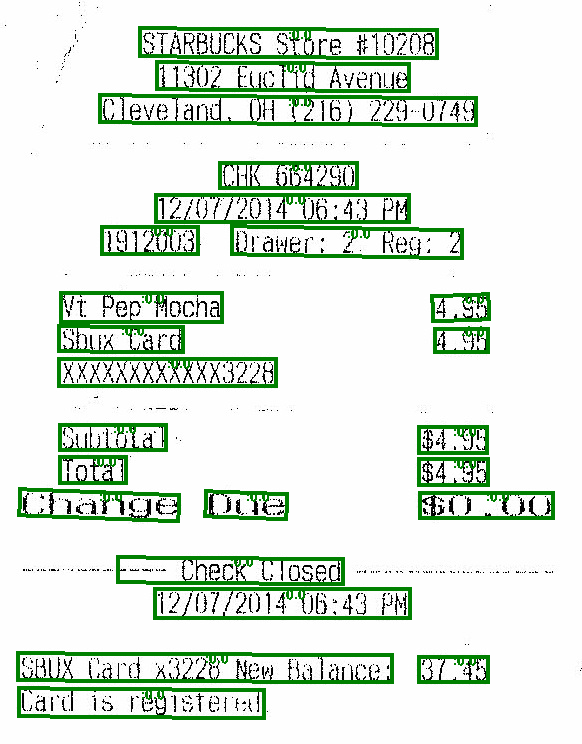

STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND, OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAWER: 2. REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
---- CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


In [7]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")
print(("").join([x.text for x in result.select("text").collect()]))